# Составляющие нейронной сети

In [1]:
import torch
import pandas as pd
from tqdm import trange

### 0. Инициализация генератора случайных чисел

In [2]:
_ = torch.manual_seed(1)

### 1. Данные
Обучающая выборка для задачи классификации

In [9]:
def get_xor_data():
    x = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32)
    y = torch.tensor([0, 1, 1, 0], dtype=torch.float32)
    return x, y

x, y = get_xor_data()
print(f'Items: {len(x)}')

Items: 4


### 2. Функция потерь

Эмпирический риск, оптимизируемый функционал, **objective**. Определяет задачу оптимизации, интерпретацию весов.

Функция потерь измеряет отличие предсказанного значения от истинного.

*mean* -- среднее значение функции потерь по обучающей выборке (эмпирический риск по определению).

Минимизация эмперического риска --  принцип статистической теории обучения.

In [10]:
loss_fn = torch.nn.MSELoss(reduction='mean')  #  none | mean | sum

### 3. Архитектура нейронной сети, инициализация весов
Определяет вид функции, связывающей входные и выходные данные

In [27]:
def get_2_layer_model():
    return torch.nn.Sequential(
    torch.nn.Linear(in_features=2, out_features=2, bias=True),  # Полносвязный слой
    torch.nn.Sigmoid(),                                         # Функция активации
    torch.nn.Linear(2, 1),
    torch.nn.Sigmoid(),
    torch.nn.Flatten(start_dim=0, end_dim=1)
)

model = get_2_layer_model()
n_params = sum(
    [param.numel() for param in model.parameters()]
)  # model.parameters() -- генератор
n_trainable_layers = len(
    [layer for layer in model if list(layer.parameters())]
)
print(f'Model contains {n_params} parameters in {n_trainable_layers} layers')

Model contains 9 parameters in 2 layers


### 4. Метод оптимизации

In [28]:
optimizer = torch.optim.SGD(
    model.parameters(),  # Оптимизируемые параметры
    lr=3,               # Скорость обучения
    weight_decay=0,      # Множитель L2 регуляризации
    momentum=0,          # Величина момента инерции
    dampening=0,         # ??? (Аммортизация момента?!  # TODO
    nesterov=False       # Выбор метода вычисления момента [http://www.cs.toronto.edu/~hinton/absps/momentum.pdf]
)

### 5. Градиентный спуск с обратным распространением ошибки

In [38]:
n_epochs = 500                    # Количество эпох обучения
loss_history = pd.Series(index=range(n_epochs), dtype=float)
for i in trange(n_epochs):
    pred = model(x)               # Прямой проход, вызов методов forward
    loss = loss_fn(pred, y)       # Вычисление эмперического риска
    loss_history[i] = loss
    optimizer.zero_grad()         # Инициализация param.grad нулями (при обратном проходе они аккумулируются). Аналог: model.zero_grad()
    loss.backward()               # Обратный проход: вычисление градиентов, вызов методов backward
    optimizer.step(closure=None)  # Применение градиентов к весам сети

100%|██████████████████████████████████████| 500/500 [00:00<00:00, 3056.93it/s]


0     0.0006
1     0.0006
2     0.0006
3     0.0006
4     0.0006
       ...  
495   0.0004
496   0.0004
497   0.0004
498   0.0004
499   0.0004
Length: 500, dtype: float64


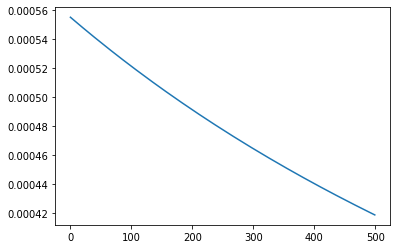

In [39]:
pd.options.display.float_format = '{:.4f}'.format
print(loss_history)
_ = loss_history.plot()